In [2]:
import pandas as pd
import yaml
root_path = '/local/work/merengelke/aipal/'
config = yaml.load(open('cfg.yaml', 'r'), Loader=yaml.FullLoader)

cities_countries = config['cities_countries']
paths = [f"{root_path}{city_country}/aipal/predict.csv" for city_country in cities_countries]

df = pd.DataFrame()
for path in paths:
    df_small = pd.read_csv(path)
    df_small['city_country'] = path.split('/')[-3]
    df = pd.concat([df, df_small])
    
# age over 18
if config['is_adult']:
    df = df[df['age'] > 18]
else:
    df = df[df['age'] <= 18]
df.drop(columns=['ELN', 'Diagnosis', 'additional.diagnosis.details..lineage.etc', 'lineage.details'], inplace=True, errors='ignore')
features = config['feature_columns']

# remove all empty chars form class
df['class'] = df['class'].str.strip()
df = df.groupby('city_country').filter(lambda x: len(x) > 30)

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

def calculate_auc(data):
    classes = ["ALL", "AML", "APL"]
    y_true = label_binarize(data["class"], classes=classes)
    auc_scores = {
        cat: (
            roc_auc_score(y_true[:, i], data[f"prediction.{cat}"])
            if len(np.unique(y_true[:, i])) > 1
            else float("nan")
        )
        for i, cat in enumerate(classes)
    }
    return auc_scores

print("Baseline AUC")
calculate_auc(df)


Baseline AUC


{'ALL': 0.7940393730062769,
 'AML': 0.8191983554311927,
 'APL': 0.9142254865152368}

In [4]:
prediction_columns = ['prediction.ALL', 'prediction.AML', 'prediction.APL']
df['prediction.ALL'].idxmax()

df["predicted_class"] = (
    df[prediction_columns]
    .idxmax(axis=1)
    .str.replace("prediction.", "", regex=False)
)

df_false = df[df["class"] != df["predicted_class"]]
df_true = df[df["class"] == df["predicted_class"]]

In [5]:
df[features].describe()

,Fibrinogen_g_L,MCV_fL,Monocytes_percent,LDH_UI_L,PT_percent,MCHC_g_L,Lymphocytes_G_L,age,Monocytes_G_L,Platelets_G_L
count,3099.000000,3444.000000,3302.000000,3382.000000,3395.000000,3360.000000,3314.000000,3464.000000,3302.000000,3460.000000
mean,3.618509,95.110163,18.131911,624.884506,75.094049,334.510417,8.403701,52.518945,6.029916,72.054384
std,1.935797,19.594247,58.681378,820.815156,23.504898,21.099712,25.796651,17.836342,18.443829,88.089277
min,0.000000,56.000000,0.000000,36.000000,0.000000,168.000000,0.000000,18.106850,0.000000,0.070000
25%,2.420000,88.500000,1.863768,239.925000,62.459060,324.000000,0.980000,38.000000,0.080000,24.000000
50%,3.430000,94.300000,7.364095,376.950000,73.650590,335.000000,2.020000,53.000000,0.470000,45.000000
75%,4.575000,100.725000,26.189902,681.000000,88.000000,345.000000,5.300000,67.000000,3.000000,91.000000
max,33.000000,1114.400000,3000.000000,11396.000000,205.000000,1000.000000,402.800000,121.440000,225.580000,2146.000000


AUC Before Outlier Removal:
{'ALL': 0.7940393730062769, 'AML': 0.8191983554311927, 'APL': 0.9142254865152368}

Classification Report Before Outlier Removal:
              precision    recall  f1-score   support

         ALL       0.44      0.48      0.46       549
         AML       0.84      0.86      0.85      2495
         APL       0.70      0.54      0.61       420

    accuracy                           0.76      3464
   macro avg       0.66      0.63      0.64      3464
weighted avg       0.76      0.76      0.76      3464


Confusion Matrix Before Outlier Removal:
[[ 261  256   32]
 [ 289 2142   64]
 [  38  154  228]]

AUC After Outlier Removal:
{'ALL': 0.80539643678839, 'AML': 0.8271304521701387, 'APL': 0.9212620389271281}

Classification Report After Outlier Removal:
              precision    recall  f1-score   support

         ALL       0.46      0.50      0.48       506
         AML       0.84      0.86      0.85      2291
         APL       0.71      0.56      0.62     

/tmp/ipykernel_3537683/2548624908.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['pca_one'] = pca_result[:, 0]
/tmp/ipykernel_3537683/2548624908.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['pca_two'] = pca_result[:, 1]


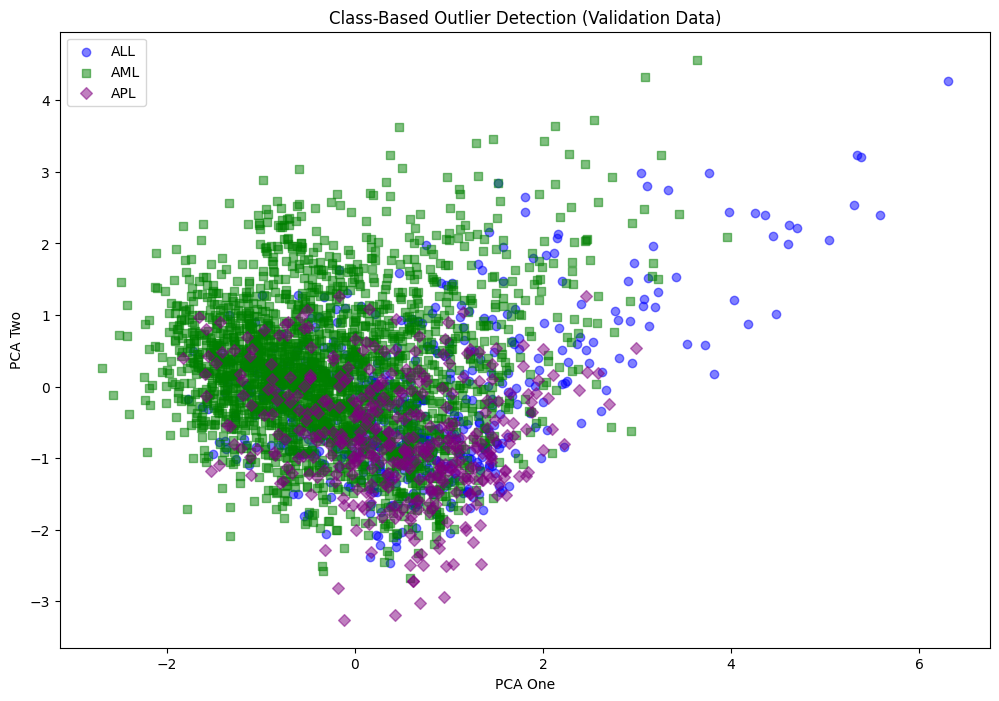

In [7]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define the features
features = ["age", "MCV_fL", "PT_percent", "LDH_UI_L", "MCHC_g_L", 
            "WBC_G_L", "Fibrinogen_g_L", "Monocytes_G_L", 
            "Platelets_G_L", "Lymphocytes_G_L", "Monocytes_percent"]

# Preprocess df_true
data_cleaned = df_true.copy().reset_index(drop=True)

# Impute missing values using median
imputer = SimpleImputer(strategy="median")
data_cleaned[features] = imputer.fit_transform(data_cleaned[features])

# Standardize features
scaler = StandardScaler()
data_cleaned[features] = scaler.fit_transform(data_cleaned[features])

# Initialize an outlier column
data_cleaned['outlier'] = 0

# Apply Isolation Forest and LOF per class
for class_label in data_cleaned['class'].unique():
    # Subset the data for the current class
    class_data = data_cleaned[data_cleaned['class'] == class_label]
    original_index = class_data.index  # Preserve the original index

    # Apply Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_outliers = iso_forest.fit_predict(class_data[features])

    # Apply Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    lof_outliers = lof.fit_predict(class_data[features])

    # Combine outlier detection results
    combined_outliers = ((iso_outliers == -1) | (lof_outliers == -1)).astype(int)

    # Update the main DataFrame's outlier column
    data_cleaned.loc[original_index, 'outlier'] = combined_outliers

# Filter out the detected outliers
data_no_outliers = data_cleaned[data_cleaned['outlier'] == 0].reset_index(drop=True)

# -----------------------
# Validate on Full Dataset (df)
# -----------------------
# Preprocess df
df_cleaned = df.copy().reset_index(drop=True)
df_cleaned[features] = imputer.transform(df_cleaned[features])
df_cleaned[features] = scaler.transform(df_cleaned[features])

# Assign outliers based on models trained on df_true
df_cleaned['outlier'] = 0
for class_label in df_cleaned['class'].unique():
    class_data = df_cleaned[df_cleaned['class'] == class_label]
    original_index = class_data.index

    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_outliers = iso_forest.fit_predict(class_data[features])

    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    lof_outliers = lof.fit_predict(class_data[features])

    combined_outliers = ((iso_outliers == -1) | (lof_outliers == -1)).astype(int)
    df_cleaned.loc[original_index, 'outlier'] = combined_outliers

# Evaluate Before Outlier Removal
def calculate_auc(data):
    classes = ["ALL", "AML", "APL"]
    y_true = label_binarize(data["class"], classes=classes)
    auc_scores = {
        cat: (
            roc_auc_score(y_true[:, i], data[f"prediction.{cat}"])
            if len(set(y_true[:, i])) > 1
            else float("nan")
        )
        for i, cat in enumerate(classes)
    }
    return auc_scores

print("AUC Before Outlier Removal:")
print(calculate_auc(df_cleaned))

print("\nClassification Report Before Outlier Removal:")
y_true_before = df_cleaned['class']
y_pred_before = df_cleaned[['prediction.ALL', 'prediction.AML', 'prediction.APL']].idxmax(axis=1).apply(lambda x: x.split('.')[1])
print(classification_report(y_true_before, y_pred_before, target_names=["ALL", "AML", "APL"]))

print("\nConfusion Matrix Before Outlier Removal:")
print(confusion_matrix(y_true_before, y_pred_before))

# Remove Outliers
df_no_outliers = df_cleaned[df_cleaned['outlier'] == 0]

# Evaluate After Outlier Removal
print("\nAUC After Outlier Removal:")
print(calculate_auc(df_no_outliers))

print("\nClassification Report After Outlier Removal:")
y_true_after = df_no_outliers['class']
y_pred_after = df_no_outliers[['prediction.ALL', 'prediction.AML', 'prediction.APL']].idxmax(axis=1).apply(lambda x: x.split('.')[1])
print(classification_report(y_true_after, y_pred_after, target_names=["ALL", "AML", "APL"]))

print("\nConfusion Matrix After Outlier Removal:")
print(confusion_matrix(y_true_after, y_pred_after))

# Visualize PCA for validation data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_no_outliers[features])
df_no_outliers['pca_one'] = pca_result[:, 0]
df_no_outliers['pca_two'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
for class_label, color, marker in zip(["ALL", "AML", "APL"], ["blue", "green", "purple"], ["o", "s", "D"]):
    subset = df_no_outliers[df_no_outliers['class'] == class_label]
    plt.scatter(subset['pca_one'], 
                subset['pca_two'], 
                color=color, marker=marker, label=f'{class_label}', alpha=0.5)

plt.title('Class-Based Outlier Detection (Validation Data)')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.legend()
plt.show()